<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code3_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODE 3.11 FITTING 9-PEAK TL DATA USING THE TRANSFORMED  KV-TL equation

In this section we use the transformed KV-TL equations to fit a 9-peak
LiF (TLD-700) glow curve from the GLOCANIN project (Bos et al. Bos1993d,Bos1994).

This Python code can be easily generalized to a TL glow curve with
any number of peaks. In some situations, when attempting to analyze
a multipeak TL glow curve as in this case, it may be necessary to
increase the maximum number of iterations, by using e.g. the optional
parameter `maxfev=10000` when calling the `optimize.curve_fit()` 
function. 

The code is based on the transformed KV-TL:


Code 3.11 calls two functions `TL(T,imax,R,E,Tmax)}`
and `total_TL(T,*inis)` to evaluate the intensity
of individual peaks and also the sum of the 9 peaks, respectively.
Python `for` loops are used to plot the 9 individual peaks.

The FOM=3 % and a histogram plot of the distribution of the residuals
of the fitting process is shown underneath the data. 




FOM= 3.04  %
+----------+------+--------+----------+
|   Imax   |  R   | E (eV) | Tmax (K) |
+----------+------+--------+----------+
| 9784.89  | 0.01 |  1.23  |  387.2   |
| 21072.04 | 0.03 |  1.32  |  428.46  |
| 27527.03 | 0.1  |  1.91  |  462.46  |
| 52836.45 | 0.04 |  2.47  |  488.03  |
| 8958.01  | 0.01 |  1.27  |  491.91  |
| 5920.52  | 0.04 |  0.92  |  525.15  |
| 6067.62  | 0.05 |  2.36  |  559.38  |
| 1840.35  | 0.0  |  2.87  |  583.57  |
| 2419.12  | 0.15 |  1.85  |  603.13  |
+----------+------+--------+----------+


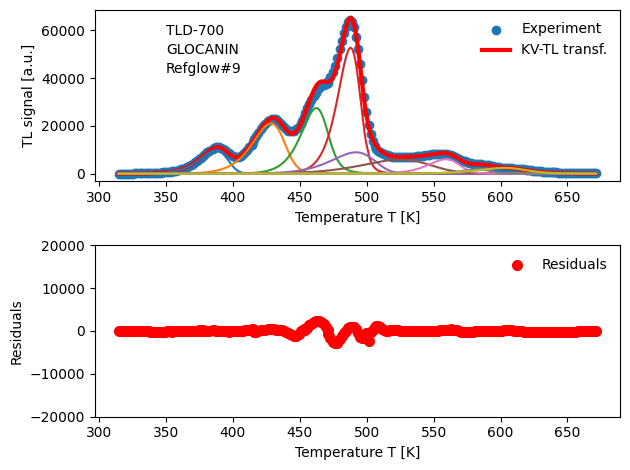

In [ ]:
#Deconvolution of 9-peak TL using the transformed KV-TL eqt

from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import requests
from scipy.special import wrightomega

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/Refglow009.txt'
response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0], data[:, 1]

# plot the data
plt.scatter(x_data, y_data, label='Experiment')

kB=8.617E-5 
def TL(T,imax,R,E,Tmax):
    F=kB*(T**2.0)*np.exp(-E/(kB*T))*(1-2*kB*T/E)/E
    Fm=kB*(Tmax**2.0)*np.exp(-E/(kB*Tmax))*(1-2*kB*Tmax/E)/E
    a=kB*Tmax**2.0*(1-1.05*R**1.26)
    Z=R/(1-R)-np.log((1-R)/R)+(F*E*np.exp(E/(kB*Tmax)))/a
    Zm=R/(1-R)-np.log((1-R)/R)+(Fm*E*np.exp(E/(kB*Tmax)))/a
    argW=wrightomega(Z)
    argWm=wrightomega(Zm)
    return imax*np.exp(-E/(kB*T)*(Tmax-T)/Tmax)*\
    (argWm+argWm**2.0)/(argW+argW**2.0)  
def total_TL(T, *inis): 
    u=np.array([0 for i in range(len(x_data))])
    imaxs,     Rs,        Es,         Tmaxs=\
    inis[0:9],inis[9:18],inis[18:27], inis[27:36]
    for i in range(9):
        u=u+TL(T,imaxs[i],Rs[i], Es[i],Tmaxs[i])
    return u
inis = (9824,21009,27792,50520,7153,5496,6080,1641,2316,
0.01,0.01,.01,.01,.01,.01,.01,.01,.01,
1.24,1.36,2.10, 2.65,1.43, 1.16,2.48,2.98,2.25,
 387,428,462,488,493,528,559,585, 602)
params, params_covariance = optimize.curve_fit(total_TL,\
x_data,y_data,p0=inis)
plt.subplot(2,1, 1)
plt.scatter(x_data, y_data, label='Experiment')
plt.plot(x_data, total_TL(x_data, 
*params),c='r',linewidth=3, label='KV-TL transf.')
for i in range(9):
    plt.plot(x_data, TL(x_data, *params[i:36:9]))
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]')
plt.xlabel(r'Temperature T [K]')
plt.text(350, 58000,'TLD-700')
plt.text(350, 50000,'GLOCANIN')
plt.text(350, 42000,'Refglow#9')
plt.subplot(2,1, 2)
plt.scatter(x_data,total_TL(x_data, *params)
   -y_data,c='r',linewidth=2,label='Residuals')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals')
plt.xlabel(r'Temperature T [K]')
plt.ylim(-20000,20000)
plt.tight_layout()
res=total_TL(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),2)
myTable = PrettyTable(["Imax", "R", "E (eV)", "Tmax (K)"]) 
for i in range(9):
    myTable.add_row(np.round(params[i:36:9],2))
print('FOM=',FOM,' %')
print(myTable)
plt.show()